# Стекинг для задачи регрессии

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error

from category_encoders import CatBoostEncoder
import statistics


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
solution_df = pd.read_csv('solution.csv')

train_df.head()

,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host,target
0,Belle Harbor 4 BR 2 bath- 1 bl from Beach,40327248,Sarina,Queens,Neponsit,40.57215,-73.85822,Entire home/apt,350,2,5,2019-07-07,2.88,1,334
1,"Come see Brooklyn, New York",13617520,Howard T.,Brooklyn,Clinton Hill,40.69172,-73.96934,Shared room,40,5,8,2015-02-25,0.13,1,0
2,Large 2Br on W71st & Columbus Feb 19-28,26754726,Julie,Manhattan,Upper West Side,40.77673,-73.98011,Entire home/apt,200,5,0,NaN,NaN,1,0
3,Perfect bedroom. Near Subways Columbia CityCol...,16721721,Federico,Manhattan,Harlem,40.81530,-73.95080,Private room,65,2,18,2018-11-04,0.64,1,0
4,Cozy Sun Filled Fresh Guest Room in Artsy Bush...,22246463,Lisa,Brooklyn,Bushwick,40.70230,-73.92935,Private room,99,2,26,2019-06-23,0.76,1,155


### Обработка данных

(Анализировали, почему исключаем эти признаки, на семинаре [пропуски и тп])

In [ ]:
train_df.drop(['_id', 'last_dt', 'name', 'host_name'], axis=1, inplace=True)
test_df.drop(['_id', 'last_dt', 'name', 'host_name'], axis=1, inplace=True)

In [ ]:
y_train = train_df['target']
X_train = train_df.drop(['target'], axis=1)

y_test = solution_df['prediction']
X_test = test_df

Проверяем данные на пропуски и нулевые значения:

In [ ]:
nan_train = X_train.isna().sum()
nan_test = X_test.isna().sum()

print(nan_train[nan_train > 0], nan_test[nan_test > 0])

avg_reviews    7502
dtype: int64 avg_reviews    2550
dtype: int64


In [ ]:
avg_reviews_median = X_train['avg_reviews'].median()
X_train.fillna({'avg_reviews': avg_reviews_median}, inplace=True)
X_test.fillna({'avg_reviews': avg_reviews_median}, inplace=True)

Кодируем категориальные признаки с помощью CatBoostEncoder()

In [ ]:
cat_columns = ['name', 'location_cluster', 'location', 'type_house']

for col in cat_columns:
    if col in X_train.columns:
        enc = CatBoostEncoder()
        X_train[col] = enc.fit_transform(X_train[col], y_train)
        X_test[col] = enc.transform(X_test[col])


### Создаем и обучаем 5 моделей на исходных данных

In [ ]:
base_models = {
    'rf': RandomForestRegressor(n_estimators=100, random_state=42),
    'xgb': XGBRegressor(n_estimators=100, random_state=42),
    'lgb': LGBMRegressor(n_estimators=100, random_state=42),
    'svr': SVR(kernel='rbf', C=10, epsilon=0.1, gamma='scale'),
    'lr': LinearRegression()
}

In [ ]:
nan_train = X_train.isna().sum()
print(nan_train[nan_train > 0])

Series([], dtype: int64)


In [ ]:
from sklearn.base import clone

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_test = len(X_test)
oof_preds = np.zeros((len(X_train), len(base_models)))
fold_test_preds = np.zeros((5, 5, n_test))

for model_idx, (model_name, model) in enumerate(base_models.items()):
    temp_oof = np.zeros(len(X_train))

    for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        model_fold = clone(model)
        model_fold.fit(X_tr, y_tr)

        val_pred = model_fold.predict(X_val)
        temp_oof[val_idx] = val_pred
        fold_test_preds[model_idx, fold, :] = model_fold.predict(X_test)

    oof_preds[:, model_idx] = temp_oof

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2148
[LightGBM] [Info] Number of data points in the train set: 29336, number of used features: 10
[LightGBM] [Info] Start training from score 112.737353
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2149
[LightGBM] [Info] Number of data points in the train set: 29337, number of used features: 10
[LightGBM] [Info] Start training from score 112.767222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2148
[LightGBM] [Info] Number of data points in the train set: 29337, number of used features: 10
[LightGBM] [Info] Start

In [ ]:
print(oof_preds.shape)

(36671, 5)


### Мета-модель

Усредяю предсказания на фолдах для получения размеров (5, n_test)

In [ ]:
test_meta_features = np.mean(fold_test_preds, axis=1).T

In [ ]:
meta_model = LinearRegression()
meta_model.fit(oof_preds, y_train)

LinearRegression()

In [ ]:
final_preds = meta_model.predict(test_meta_features)

In [ ]:
mse = mean_squared_error(y_test, final_preds)
print(f'MSE мета-модели: {mse:.4f}')

MSE мета-модели: 10930.3582


Не такой плохой результат! Не идеально, но явно лучше, чем результаты отдельных моделей, в чем убежимся чуть ниже. Также подсчитаем неопределенности:

### Подсчет неопределенностей

In [ ]:
def calculate_aleatoric_uncertainty(y_true, y_pred):
  n = len(y_true)
  residuals = y_true - y_pred
  aleatoric_uncertainty = np.sum(residuals**2) / n

  return aleatoric_uncertainty


def calculate_epistemic_uncertainty(y_pred_ensemble):
  mean_prediction = np.mean(y_pred_ensemble, axis=0)
  m = y_pred_ensemble.shape[0]

  squared_diffs = np.sum((y_pred_ensemble - mean_prediction)**2, axis=0)
  epistemic_uncertainty = squared_diffs / m
  return epistemic_uncertainty

In [ ]:
al = [calculate_aleatoric_uncertainty(y_test, i) for i in final_preds]
ep = calculate_epistemic_uncertainty(final_preds)
aleatoric = np.mean(al)
epistemic = np.mean(ep)

In [ ]:
aleatoric, epistemic

(23845.957951021952, 6474.314910230883)

In [ ]:
total_uncertainty = epistemic + aleatoric
total_uncertainty

30320.272861252834

* Алеаторная неопределенность - Связана с шумом в данных, который модель не может устранить.
* Эпистемическая неопределенность - Возникает из-за недостатка знаний или данных для обучения модели.

**Выводы:** Алеаторная неопределенность в ~3.7 раза больше, чем эпистемическая => основной источник ошибок — качество данных, модель уже достаточно хорошо обучена, но данные содержат "естественный" шум, может случайностей или недостающих признаков

Эпистемическая неопределенность заметная, но явно ментше алеаторной, значит ансамбль моделей дал хорошее "покрытие" пространства, разнообразия в обучении хватает

Значит, для улучшения результатов стоит попробовать не усложнять модель, а лучше создать новые признаки или очистить данные, поискать из-за чего модет быть шум, может есть резкие скачки или выбросы

### Визуализация зависимости между неопределенностью предсказаний и ошибкой

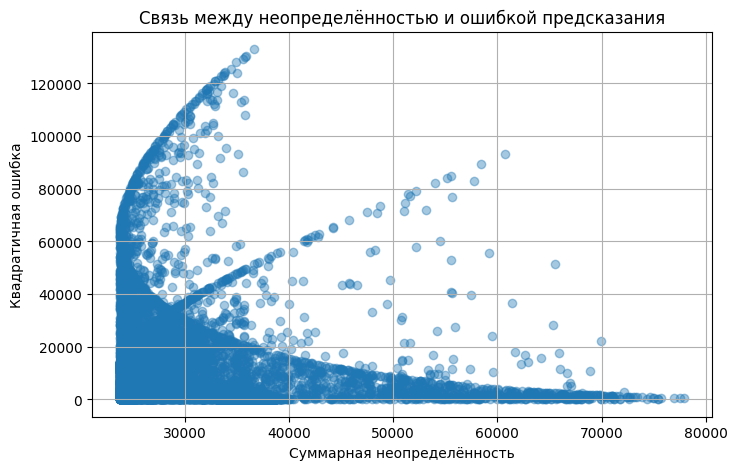

In [ ]:
import matplotlib.pyplot as plt

errors = (y_test - final_preds) ** 2
tot = al + ep

plt.figure(figsize=(8, 5))
plt.scatter(tot, errors, alpha=0.4)
plt.xlabel("Суммарная неопределённость")
plt.ylabel("Квадратичная ошибка")
plt.title("Связь между неопределённостью и ошибкой предсказания")
plt.grid(True)
plt.show()

Видно, что низкая неопределённость почти всегда означает маленькую ошибку (<25 000), но есть объекты с очень большой ошибкой (>100 000) даже при неопределенности 25 000–30 000, это как раз может быть из-за выбросов и пропущенных признаков. При неопределенности >40 000 ошибка наоборот уменьшается, может быть потому что модель может как-то "перестраховывается" в прогнозах при большой неуверенности... возможно что-то такое

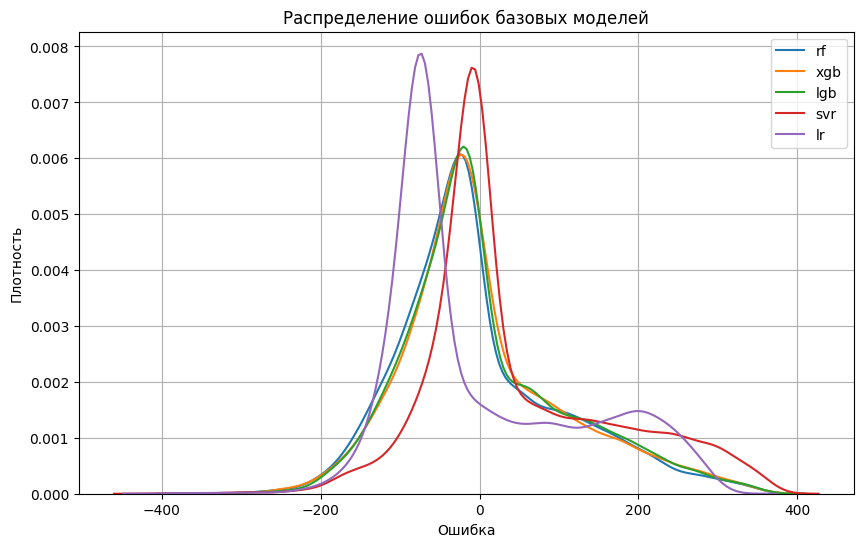

In [ ]:
model_avg_preds = np.mean(fold_test_preds, axis=1)
df_stacking = pd.DataFrame(model_avg_preds.T, columns=list(base_models.keys()))


plt.figure(figsize=(10, 6))
for one_col in df_stacking.columns:
    sns.kdeplot(y_test - df_stacking[one_col], label=one_col)

plt.title("Распределение ошибок моделей")
plt.xlabel("Ошибка")
plt.ylabel("Плотность")
plt.legend()
plt.grid(True)
plt.show()


Видим, что 3 из пяти моделей ведут себя схоже, дают похожие предсказания, предсказания же линейной регрессии и SVR сильнее отличаются как от первых трех моделей, так и друг от друга, что хорошо, так как дает нам более разнообразную картину, что в усреднении должно дать лучшие результаты)

### Сравнение с моделями по-отдельности

In [ ]:
final_models = {}
for model_name, model in base_models.items():
    new_m = clone(model)
    new_m.fit(X_train, y_train)
    final_models[model_name] = new_m

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 36671, number of used features: 10
[LightGBM] [Info] Start training from score 112.766628


In [ ]:
all_preds = []
for m_name, m_obj in final_models.items():
    p = m_obj.predict(X_test)
    all_preds.append(p)
separate_preds = np.array(all_preds).T

In [ ]:
for i in range(separate_preds.shape[1]):
    mse = mean_squared_error(y_test, separate_preds[:, i])
    print(f'MSE модели {i}: {mse:.4f}')

MSE модели 0: 11230.9322
MSE модели 1: 11520.9262
MSE модели 2: 11220.7189
MSE модели 3: 11344.0167
MSE модели 4: 14452.9132


Выводы: Видим, что MSE у отдельных моделей явно проигрывает тому, что мы получили при стекинге (10930), следовательно, наш алгоритм рабочий и дает результат!

и вот ансамбль котиков для хорошего настроения)

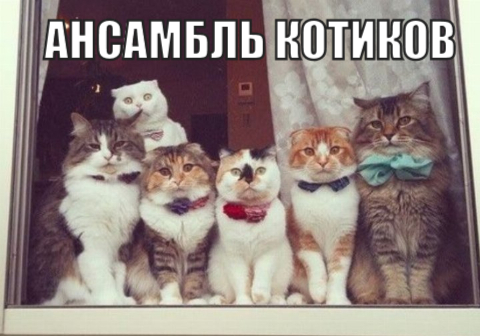